# Balancing weights for panel data

In [1]:
import numpy as np
import pyensmallen as pe
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

Low rank factor DGP

In [2]:
# Modified function to include individual time trends
def generate_panel_data(
    N, T, K, unit_fac_lb=-5, unit_fac_ub=3, sigma=0.1, trend_sigma=0.01
):
    F, L = np.random.rand(T, K), np.random.uniform(unit_fac_lb, unit_fac_ub, (N, K))
    time_trends = np.random.normal(0, trend_sigma, (N, 1)) * np.arange(T).reshape(1, T)
    epsilon = np.random.normal(0, sigma, (N, T))
    Y = np.dot(L, F.T) + epsilon + time_trends
    return Y, L


# Modified function to make treated units more unusual
def assign_treatment(L, n_treated=1, sel_mean=1):
    sel_coef = np.random.normal(sel_mean, 1, L.shape[1])
    pscore = expit(L @ sel_coef**2)
    pscore /= pscore.sum()
    assignment = np.random.choice(range(L.shape[0]), n_treated, replace=False, p=pscore)
    return assignment

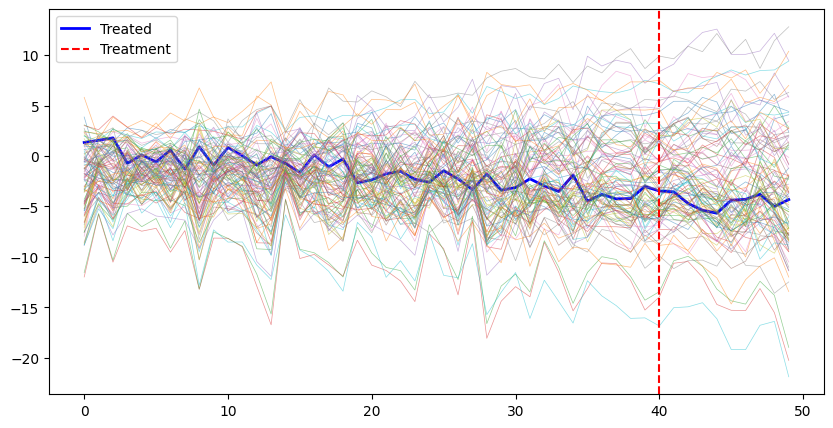

In [3]:
# Main experiment
N, T, K = 100, 50, 4
n_treated = 1
T_pre = T - 10
Y, L = generate_panel_data(N, T, K, trend_sigma=0.1)
treated_units = assign_treatment(L, n_treated)

ctrl_units = np.setdiff1d(range(Y.shape[0]), treated_units)
Y_treated = Y[treated_units].mean(axis=0)
Y_control = Y[ctrl_units]

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Y_treated, label="Treated", color="blue", linewidth=2)
ax.plot(Y_control.T, alpha=0.5, linewidth=0.5,)
ax.axvline(T_pre, color="red", linestyle="--", label="Treatment")
ax.legend()

## balancing weights


An interesting approach to synthetic control (style) weights might be to solve for the weights that minimize the difference between the treated unit and the synthetic control unit, with the proviso that the weights are have a certain structure. Common structures include
+ non-negativity
+ sum to one
+ sparsity

Classic synth chooses (1) and (2), and implicitly gets (3). If we relax (1) and (2), we can get a more flexible set of weights. We constrain the weights to be in a $\ell$-p ball, where $p$ is a parameter that we can tune.


In [4]:
def objective(w, X, y):
    return np.sum((np.dot(X, w) - y) ** 2)


def gradient(w, X, y):
    return 2 * np.dot(X.T, (np.dot(X, w) - y))


# Solve synthetic control problem using Frank-Wolfe
def synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=1.0):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    N_control = Y_control.shape[0]

    def f(w, grad):
        if grad.size > 0:
            grad[:] = gradient(w, Y_control.T, Y_treated)
        return objective(w, Y_control.T, Y_treated)

    # pnorm Frank-Wolfe solution
    optimizer = pe.FrankWolfe(p=p, max_iterations=10000, tolerance=1e-8)
    initial_w = np.ones(N_control) / N_control
    w_opt = optimizer.optimize(f, initial_w)
    return w_opt


# just run OLS
def synthetic_control_linear(Y, treated_units, T_pre):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    coef = np.linalg.lstsq(Y_control.T, Y_treated, rcond=None)[0]
    return coef

In [5]:
# synth classic
from scipy.optimize import fmin_slsqp
from toolz import partial


def synthetic_control_linear_simplex(Y, treated_units, T_pre):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    _w = np.repeat(1 / Y_control.shape[0], Y_control.shape[0])
    w_bnds = tuple((0, 1) for i in range(Y_control.shape[0]))
    simplex_synth = fmin_slsqp(
        partial(objective, X=Y_control.T, y=Y_treated),
        _w,
        f_eqcons=lambda x: np.sum(x) - 1, # normalisation
        bounds=w_bnds,                    # simplex
        disp=False,
    )
    return simplex_synth

In [6]:
# Solve synthetic control problems
w_opt_1 = synthetic_control_frank_wolfe(Y, treated_units, T_pre)
w_opt_2 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=2.0)
w_opt_linear = synthetic_control_linear(Y, treated_units, T_pre)
w_simplex = synthetic_control_linear_simplex(Y, treated_units, T_pre)

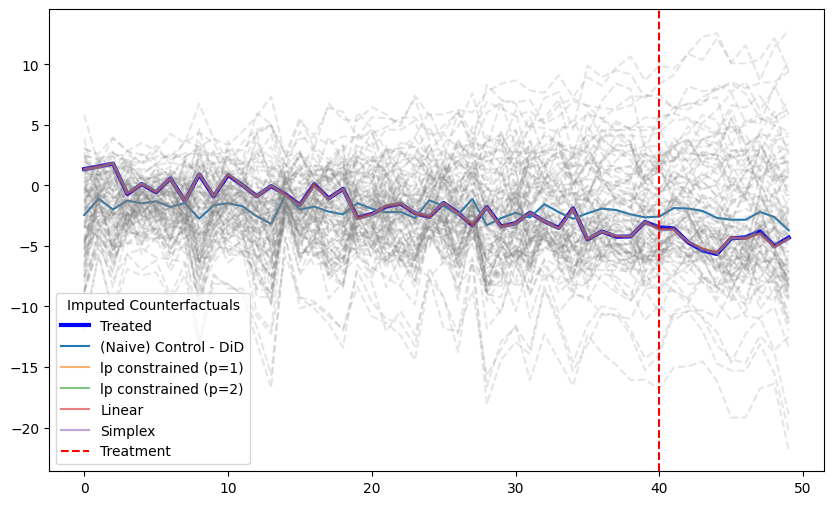

In [7]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

ctrl_units = np.setdiff1d(range(Y.shape[0]), treated_units)
Y_treated = Y[treated_units].mean(axis=0)
Y_control = Y[ctrl_units]

ax.plot(Y_treated, label="Treated", color="blue", linewidth=3)
ax.plot(Y_control.mean(axis=0), label="(Naive) Control - DiD")
ax.plot(Y_control.T, alpha=0.2, color="gray", linestyle="--")

ax.plot(np.dot(Y_control.T, w_opt_1), alpha=0.6, label="lp constrained (p=1)")
ax.plot(np.dot(Y_control.T, w_opt_2), alpha=0.6, label="lp constrained (p=2)")
ax.plot(np.dot(Y_control.T, w_opt_linear), alpha=0.6, label="Linear")
ax.plot(np.dot(Y_control.T, w_simplex), alpha=0.6, label="Simplex")

ax.axvline(T_pre, color="red", linestyle="--", label="Treatment")
ax.legend(title="Imputed Counterfactuals")

Every estimator besides Diff in Diff (uniform weights) perfectly fits the pre-treatment data.

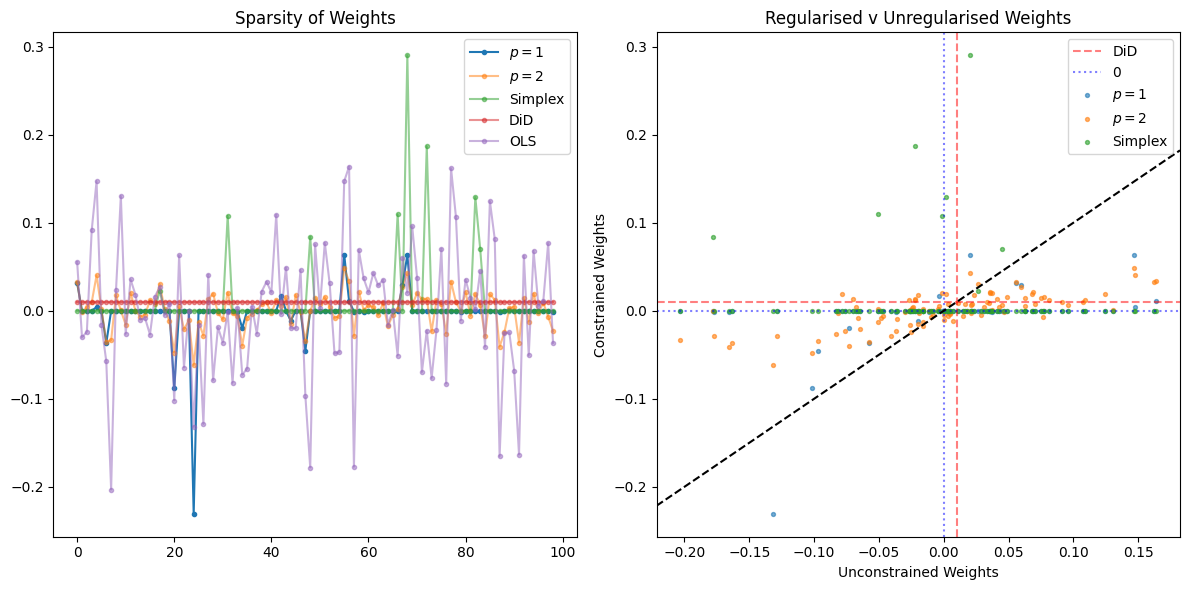

In [8]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[1].axvline(1 / Y_control.shape[0], alpha=0.5, color="red", linestyle="--", label = "DiD")
ax[1].axhline(1 / Y_control.shape[0], alpha=0.5, color="red", linestyle="--")
ax[1].axvline(0, color="blue",        alpha=0.5, linestyle=":", label = '0')
ax[1].axhline(0, color="blue",        alpha=0.5, linestyle=":")

ax[0].plot(w_opt_1, label=r"$p=1$", marker=".")
ax[0].plot(w_opt_2, label=r"$p=2$", marker=".", alpha=0.5)
ax[0].plot(w_simplex, label="Simplex", marker=".", alpha=0.5)
ax[0].plot(
    np.repeat(1 / Y_control.shape[0], Y_control.shape[0]),
    label="DiD",
    marker=".",
    alpha=0.5,
)
ax[0].plot(w_opt_linear, label="OLS", marker=".", alpha=0.5)
ax[0].legend()
ax[0].set_title("Sparsity of Weights")
ax[1].scatter(w_opt_linear, w_opt_1,   s = 8, alpha=0.6, label="$p=1$")
ax[1].scatter(w_opt_linear, w_opt_2,   s = 8, alpha=0.6, label="$p=2$")
ax[1].scatter(w_opt_linear, w_simplex, s = 8, alpha=0.6, label="Simplex")
ax[1].axline(
    [w_opt_linear.min(), w_opt_linear.min()],
    [w_opt_linear.max(), w_opt_linear.max()],
    color="black",
    linestyle="--",
)

ax[1].legend()
ax[1].set_xlabel("Unconstrained Weights")
ax[1].set_ylabel("Constrained Weights")
ax[1].set_title("Regularised v Unregularised Weights")
f.tight_layout()


## Simulation Study

Repeat the above procedure (with true effect = 0) 1000 times, and plot the distribution of the estimated effect. 

In [9]:
from joblib import Parallel, delayed

N, T, K = 100, 50, 4
n_treated = 5
T_pre = T - 10


def one_run(i=1):
    np.random.seed(i)
    Y, L = generate_panel_data(N, T, K)
    treated_units = assign_treatment(L, n_treated)
    ctrl_id = np.setdiff1d(range(N), treated_units)
    # compute weights
    w_opt_1 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=1.0)
    w_opt_2 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=2.0)
    w_opt_linear = synthetic_control_linear(Y, treated_units, T_pre)
    w_simplex = synthetic_control_linear_simplex(Y, treated_units, T_pre)
    # compute biases (true effect is 0)
    bias_did = Y[treated_units, T_pre:].mean(axis=0) - Y[ctrl_id, T_pre:].mean(axis=0)
    bias_reg_1 = np.dot(Y[ctrl_id, T_pre:].T, w_opt_1) - Y[treated_units, T_pre:].mean(
        axis=0
    )
    bias_reg_2 = np.dot(Y[ctrl_id, T_pre:].T, w_opt_2) - Y[treated_units, T_pre:].mean(
        axis=0
    )
    bias_ols = np.dot(Y[ctrl_id, T_pre:].T, w_opt_linear) - Y[
        treated_units, T_pre:
    ].mean(axis=0)
    bias_simplex = np.dot(Y[ctrl_id, T_pre:].T, w_simplex) - Y[
        treated_units, T_pre:
    ].mean(axis=0)

    return (
        bias_did.mean(),
        bias_reg_1.mean(),
        bias_reg_2.mean(),
        bias_ols.mean(),
        bias_simplex.mean(),
    )


one_run(1)

(2.965293468768322,
 0.01847059913639429,
 0.004352877694887597,
 -0.00855423391929001,
 0.08279615316137776)

In [10]:
%%time
res = Parallel(n_jobs=-1)(delayed(one_run)(i) for i in range(1_000))
res = np.array(res)

CPU times: user 4.37 s, sys: 447 ms, total: 4.82 s
Wall time: 5.79 s


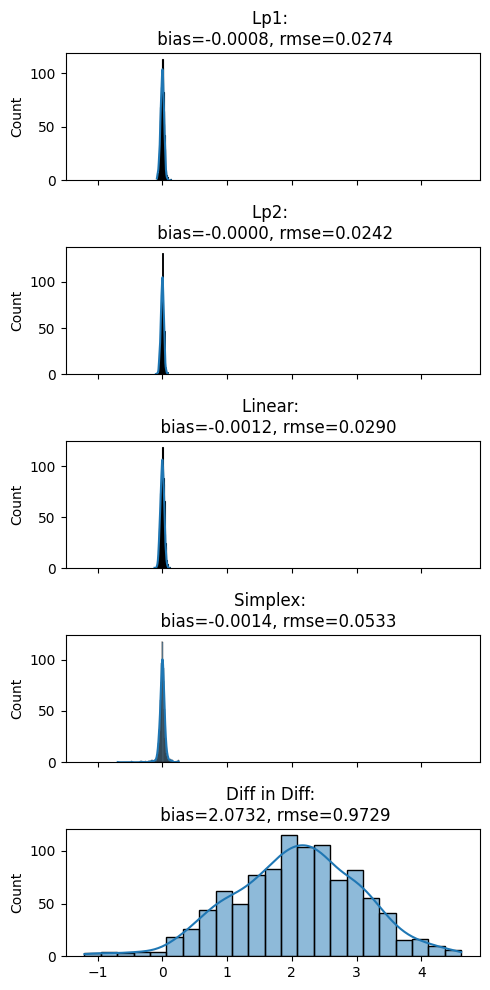

In [11]:
biases_naive, biases_reg_1, biases_reg_2, biases_ols, biases_simplex = (
    res[:, 0],
    res[:, 1],
    res[:, 2],
    res[:, 3],
    res[:, 4],
)

f, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)
sns.histplot(biases_reg_1, ax=ax[0], kde=True)
ax[0].set_title(f"Lp1: \n bias={biases_reg_1.mean():.4f}, rmse={biases_reg_1.std():.4f}")
sns.histplot(biases_reg_2, ax=ax[1], kde=True)
ax[1].set_title(f"Lp2: \n bias={biases_reg_2.mean():.4f}, rmse={biases_reg_2.std():.4f}")
sns.histplot(biases_ols, ax=ax[2], kde=True)
ax[2].set_title(f"Linear: \n  bias={biases_ols.mean():.4f}, rmse={biases_ols.std():.4f}")
sns.histplot(biases_simplex, ax=ax[3], kde=True)
ax[3].set_title(f"Simplex: \n  bias={biases_simplex.mean():.4f}, rmse={biases_simplex.std():.4f}")
sns.histplot(biases_naive, ax=ax[4], kde=True)
ax[4].set_title(f"Diff in Diff: \n bias={biases_naive.mean():.4f}, rmse={biases_naive.std():.4f}")
f.tight_layout()